In [1]:
import pandas as pd
import datetime as dt
import pandas_datareader as pdr
import numpy as np
import praw
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from praw.models import MoreComments
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout


In [2]:
stock_symbol = 'TSLA'
stock_search = 'TSLA'
stock_date = '2020-01-01'

df = pd.read_csv('test.csv', date_parser = True)
df = df.set_index('Date', drop = True)
df.index = pd.to_datetime(df.index)
data_training = df.loc[(df.index <= stock_date)]
data_test = df.loc[(df.index >= stock_date)]

data_test = data_test.reset_index()
data_training = data_training.reset_index()


print(data_training.shape)
print(data_training)
print(data_test)

data_training = data_training.drop(['Date'], axis = 1)
data_training_test = data_training
data_test = data_test.drop(['Date'], axis = 1)



(503, 7)
          Date       High        Low       Open      Close    Volume  Polarity
0   2018-01-02  64.421997  62.200001  62.400002  64.106003  21761000       0.0
1   2018-01-03  65.050003  63.110001  64.199997  63.450001  22607500       0.0
2   2018-01-04  63.709999  61.136002  62.574001  62.924000  49731500       0.0
3   2018-01-05  63.448002  62.400002  63.324001  63.316002  22956000       0.0
4   2018-01-08  67.403999  63.099998  63.200001  67.281998  49297000       0.0
..         ...        ...        ...        ...        ...       ...       ...
498 2019-12-24  85.094002  82.538002  83.671997  85.050003  40273500       0.0
499 2019-12-26  86.695999  85.269997  85.582001  86.188004  53169500       0.0
500 2019-12-27  87.061996  85.222000  87.000000  86.075996  49728500       0.0
501 2019-12-30  85.800003  81.851997  85.758003  82.940002  62932000       0.0
502 2019-12-31  84.258003  80.416000  81.000000  83.666000  51428500       0.0

[503 rows x 7 columns]
          Date     

In [3]:
# The values in the training data are not in the same range
# For getting all the values in between the range 0 to 1 use MinMaxScalar() 
# to improves the accuracy of prediction
scaler = MinMaxScaler()
data_training = scaler.fit_transform(data_training)
print(data_training)

# This sections of the code divides the data into chunks of 10 rows corresponds to 
# the length of data_traning. After dividing we are converting X_train and y_train
# into numpy arrays
X_train = []
y_train = []

for i in range(10, data_training.shape[0]):
    X_train.append(data_training[i-10:i])
    y_train.append(data_training[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

print(X_train.shape)


[[0.54470498 0.53741585 0.51555732 0.56181294 0.06049878 0.        ]
 [0.55733431 0.55566256 0.55100426 0.54879548 0.06592783 0.        ]
 [0.53038655 0.51608125 0.51898387 0.53835771 0.23988828 0.        ]
 ...
 [1.         0.99903761 1.         0.99777737 0.23986904 0.        ]
 [0.97462105 0.93146456 0.97554161 0.93554787 0.32455001 0.        ]
 [0.94361112 0.90267091 0.88184324 0.9499543  0.25077203 0.        ]]
(493, 10, 6)


In [4]:
# Build model
model = Sequential()

model.add(LSTM(units = 60, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 6)))
model.add(Dropout(0.2))

model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.summary()

model.compile(optimizer='adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 60)            16080     
_________________________________________________________________
dropout (Dropout)            (None, 10, 60)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 60)            29040     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 60)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 80)            45120     
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 80)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 120)               9

In [5]:
# past_10_days contains the data of the past 10 days required to predict the opening of the 1st day in the test data set.
past_10_days = data_training_test.tail(10)
print(past_10_days)

# We are going to append data_test to past_10_days and ignore the index of data_test
df = past_10_days.append(data_test, ignore_index = True)
print(df)

# Similar to the training data set we have to scale the test data so that all the values are in the range 0 to 1.
inputs = scaler.fit_transform(df)
inputs

# Prepare the test data like the training data.
X_test = []
y_test = []

for i in range(10, inputs.shape[0]):
    X_test.append(inputs[i-10:i])
    y_test.append(inputs[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

y_pred = model.predict(X_test)

print(scaler.scale_)

# Calcualte the original price back again
scale = 1/scaler.scale_[0]
print(scale)

# Prediction on the normal price scale
y_pred = y_pred*scale
y_test = y_test*scale

          High        Low       Open      Close    Volume  Polarity
493  77.099998  75.180000  75.797997  75.797997  42484000       0.0
494  79.043999  76.115997  76.125999  78.629997  70605000       0.0
495  81.370003  79.300003  79.463997  80.807999  90535500       0.0
496  82.599998  80.038002  82.057999  81.117996  73763500       0.0
497  84.402000  82.000000  82.356003  83.844002  66598000       0.0
498  85.094002  82.538002  83.671997  85.050003  40273500       0.0
499  86.695999  85.269997  85.582001  86.188004  53169500       0.0
500  87.061996  85.222000  87.000000  86.075996  49728500       0.0
501  85.800003  81.851997  85.758003  82.940002  62932000       0.0
502  84.258003  80.416000  81.000000  83.666000  51428500       0.0
           High         Low        Open       Close    Volume  Polarity
0     77.099998   75.180000   75.797997   75.797997  42484000       0.0
1     79.043999   76.115997   76.125999   78.629997  70605000       0.0
2     81.370003   79.300003   79.463

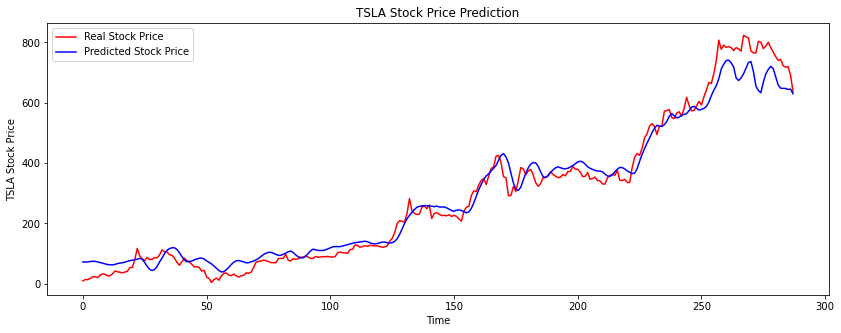

In [6]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Real Stock Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Stock Price')
plt.title(stock_symbol + ' Stock Price Prediction')
plt.xlabel('Time Series')
plt.ylabel(stock_symbol + ' Stock Price')
plt.legend()
plt.show()
